In [3]:
from google.colab import files
files.upload()

Output hidden; open in https://colab.research.google.com to view.

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
import pandas as pd
dataset=pd.read_csv('BBC News Train.csv')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [52]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [53]:
dataset.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [54]:
dataset['Category'].value_counts()

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

In [55]:
dataset['CategoryId'] = dataset['Category'].factorize()[0]  #Converting categories into category ID's
dataset.head()

,ArticleId,Text,Category,CategoryId
0,1833,worldcom ex-boss launches defence lawyers defe...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,0
3,1976,lifestyle governs mobile choice faster bett...,tech,1
4,917,enron bosses in $168m payout eighteen former e...,business,0


In [56]:
category = dataset[['Category', 'CategoryId']].drop_duplicates().sort_values('CategoryId')
category

,Category,CategoryId
0,business,0
3,tech,1
5,politics,2
6,sport,3
7,entertainment,4


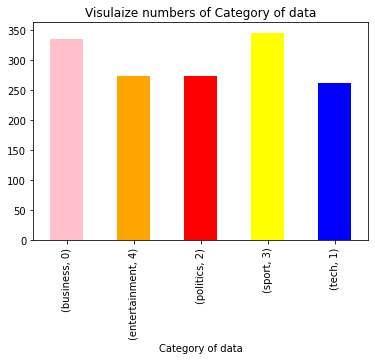

In [57]:
dataset.groupby('Category').CategoryId.value_counts().plot(kind = "bar", color = ["pink", "orange", "red", "yellow", "blue"])
plt.xlabel("Category of data")
plt.title("Visulaize numbers of Category of data")
plt.show()

In [58]:
def remove_tags(text):
  remove = re.compile(r'')
  return re.sub(remove, '', text)
dataset['Text'] = dataset['Text'].apply(remove_tags)

In [59]:
def special_char(text):               #Remove special characters
  reviews = ''
  for x in text:
    if x.isalnum():
      reviews = reviews + x
    else:
      reviews = reviews + ' '
  return reviews
dataset['Text'] = dataset['Text'].apply(special_char)

In [60]:
def convert_lower(text):                          #Convert everything to lowercase
   return text.lower()
dataset['Text'] = dataset['Text'].apply(convert_lower)
dataset['Text'][1]

'german business confidence slides german business confidence fell in february knocking hopes of a speedy recovery in europe s largest economy   munich based research institute ifo said that its confidence index fell to 95 5 in february from 97 5 in january  its first decline in three months  the study found that the outlook in both the manufacturing and retail sectors had worsened  observers had been hoping that a more confident business sector would signal that economic activity was picking up    we re surprised that the ifo index has taken such a knock   said dz bank economist bernd weidensteiner   the main reason is probably that the domestic economy is still weak  particularly in the retail trade   economy and labour minister wolfgang clement called the dip in february s ifo confidence figure  a very mild decline   he said that despite the retreat  the index remained at a relatively high level and that he expected  a modest economic upswing  to continue   germany s economy grew 1 

In [61]:
def remove_stopwords(text):                       #Removing Stopwords i.e commonly occuring words
  stop_words = set(stopwords.words('english'))
  words = word_tokenize(text)
  return [x for x in words if x not in stop_words]
dataset['Text'] = dataset['Text'].apply(remove_stopwords)
dataset['Text'][1]

['german',
 'business',
 'confidence',
 'slides',
 'german',
 'business',
 'confidence',
 'fell',
 'february',
 'knocking',
 'hopes',
 'speedy',
 'recovery',
 'europe',
 'largest',
 'economy',
 'munich',
 'based',
 'research',
 'institute',
 'ifo',
 'said',
 'confidence',
 'index',
 'fell',
 '95',
 '5',
 'february',
 '97',
 '5',
 'january',
 'first',
 'decline',
 'three',
 'months',
 'study',
 'found',
 'outlook',
 'manufacturing',
 'retail',
 'sectors',
 'worsened',
 'observers',
 'hoping',
 'confident',
 'business',
 'sector',
 'would',
 'signal',
 'economic',
 'activity',
 'picking',
 'surprised',
 'ifo',
 'index',
 'taken',
 'knock',
 'said',
 'dz',
 'bank',
 'economist',
 'bernd',
 'weidensteiner',
 'main',
 'reason',
 'probably',
 'domestic',
 'economy',
 'still',
 'weak',
 'particularly',
 'retail',
 'trade',
 'economy',
 'labour',
 'minister',
 'wolfgang',
 'clement',
 'called',
 'dip',
 'february',
 'ifo',
 'confidence',
 'figure',
 'mild',
 'decline',
 'said',
 'despite',
 'r

In [62]:
def lemmatize_word(text):
  wordnet = WordNetLemmatizer()
  return " ".join([wordnet.lemmatize(word) for word in text])
dataset['Text'] = dataset['Text'].apply(lemmatize_word)
dataset['Text'][1]

'german business confidence slide german business confidence fell february knocking hope speedy recovery europe largest economy munich based research institute ifo said confidence index fell 95 5 february 97 5 january first decline three month study found outlook manufacturing retail sector worsened observer hoping confident business sector would signal economic activity picking surprised ifo index taken knock said dz bank economist bernd weidensteiner main reason probably domestic economy still weak particularly retail trade economy labour minister wolfgang clement called dip february ifo confidence figure mild decline said despite retreat index remained relatively high level expected modest economic upswing continue germany economy grew 1 6 last year shrinking 2003 however economy contracted 0 2 last three month 2004 mainly due reluctance consumer spend latest indication growth still proving elusive ifo president han werner sinn said improvement german domestic demand sluggish export

In [63]:
x = dataset['Text']
y = dataset['CategoryId']

In [64]:
x = np.array(dataset.iloc[:,0].values)            # Counting the frequency of words
y = np.array(dataset.CategoryId.values)
cv = CountVectorizer(max_features = 5000)
x = cv.fit_transform(dataset.Text).toarray()
print("X.shape = ",x.shape)
print("y.shape = ",y.shape)

X.shape =  (1490, 5000)
y.shape =  (1490,)


In [65]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train))
print(len(x_test))

1043
447


In [71]:
gnb = GaussianNB()                                      #Training  Accuracy
y_pred = gnb.fit(x_train, y_train).predict(x_train)

In [73]:
accuracy_score(y_train, y_pred)

0.9990412272291467

In [76]:
y_predict=gnb.fit(x_train,y_train).predict(x_test)        #Testing Accuracy
accuracy_score(y_test, y_predict)

0.912751677852349